#**First Deep Reinforcement Learning Algorithm: Deep Q Learning**

#**Human-Like Artificial Intelligence for Atari Games** 

#**Open AI Gym Toolkit**

In [ ]:
import sys
import timeit
import os
import platform
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

Colab Active:  True


#**Import of all the needed Atari Roms**

In [ ]:
if OS == "Linux":
  if not os.path.exists("./Roms.rar"):
    os.system("wget http://www.atarimania.com/roms/Roms.rar") 
    os.system("unrar x -o+ ./Roms.rar >/dev/null")
    os.system("python -m atari_py.import_roms ./ROMS >/dev/null")

#**Gym Update**

In [ ]:
os.system("pip install gym==0.17.3")

if OS == "Linux":
  os.system("pip install gym[atari]")
elif OS == "Windows": 
  os.system("pip install -f https://github.com/Kojoley/atari-py/releases atari_py")     # to make it work on windows

if OS == "Linux":
  os.system("pip install pyvirtualdisplay > /dev/null 2>&1")
  os.system("apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1")

  os.system("apt-get update > /dev/null 2>&1")
  os.system("apt-get install cmake > /dev/null 2>&1")
  os.system("pip install --upgrade setuptools 2>&1")
  os.system("pip install ez_setup > /dev/null 2>&1")

#**All General Imports**

In [ ]:
import numpy as np
import glob
import io
import os.path
import base64
import math
import random
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
from collections import deque

#if OS == "Linux":
if colab_active is True: 
  from pyvirtualdisplay import Display
  Display().start()

  from IPython import display
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  import matplotlib
  import matplotlib.pyplot as plt
  %matplotlib inline

#**All Tensorflow 2.0 Imports**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json

#**All Globals**

In [ ]:
env_name = "MsPacman-v0"
#num_episodes = 500   # 7 days
num_episodes = 1
num_timesteps = 20000
#num_timesteps = 20
batch_size = 8
num_screens = 4
load_pretrained = True
summary = False

#**All Initializations**

In [ ]:
done = False
time_step = 0

#**All Functions Definitions**

We first define a function to enable video recording of gym environment and displaying it to enable video, just writing ***env = wrap_env(env)***


In ***preprocess_state***: we crop and resize the image, convert the image to greyscale, improve image contrast, normalize the image and     reshape the image.


In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                                        </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def preprocess_state(state):
    image = state[1:176:2, ::2]
    image = image.mean(axis=2)
    image[image==color] = 0
    image = (image - 128) / 128 - 1
    image = np.expand_dims(image.reshape(88, 80, 1), axis=0)

    return image

#**All Initializations**

Set the **Pacman** Environment

In [ ]:
#if OS == "Linux":
if colab_active is True: 
  gymlogger.set_level(40)                              #error only
  display = Display(visible=0, size=(1400, 900))
  display.start()

state_size = (88, 80, 1)
color = np.array([210, 164, 74]).mean()

#if OS == "Linux":
if colab_active is True: 
  env = wrap_env(gym.make(env_name))
else:
  env = gym.make(env_name)

action_size = env.action_space.n
print(env.action_space)

Discrete(9)


#**All DQL Classes Definitions**

In the class DQN: we define the state size, the action size, the replay buffer, the discount factor, define the epsilon value, define the update rate at which we want to update the target networ, define the main network, the target network and copy the weights of the main network to the target network. 

Then we define a function called **build_network** which is essentially our DQN. 




From the theory, we learned that we train **DQN** by randomly sampling a minibatch of transitions from the replay **buffer**. So, we define a function called store_transition which stores the transition information into the replay buffer.


Furthermore, in **DQN**, to take care of exploration-exploitation trade off, we select action using the **epsilon-greedy** policy. So, now we define the function called epsilon_greedy for selecting action using the **epsilon-greedy policy**.

During the **Training**: sample a mini batch of transition from the replay buffer, compute the **Q value** using the target network, compute the **Q value** using the **main network**, train the main network and update the target network **weights** by copying from the main network.




 

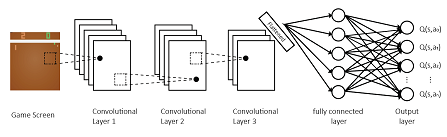

In [ ]:
class DQN:
    def __init__(self, state_size, action_size, load_pretrained = False):
        self.state_size = state_size
        self.action_size = action_size
        self.replay_buffer = deque(maxlen=5000)
        self.gamma = 0.9  
        self.epsilon = 0.8   
        self.update_rate = 1000    
        
        if load_pretrained is True and os.path.isfile("./"+ env_name.lower()+"_deep_q_network.json"): 
            with open("./"+ env_name.lower()+"_deep_q_network.json", 'r') as json_file:
                loaded_model_json = json_file.read()

            self.main_network = model_from_json(loaded_model_json)
            self.main_network.load_weights("./"+ env_name.lower()+"_deep_q_network.h5")
            print("Atari Deep Q Network Loaded Successfully...")
        else: 
            self.main_network = self.build_network()

        self.main_network.compile(loss='mse', optimizer=Adam())

        self.target_network = self.build_network()
        self.target_network.set_weights(self.main_network.get_weights())

    def build_network(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=self.state_size))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        if summary is True: 
          model.summary()
        
        return model

    def store_transistion(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        
    def epsilon_greedy(self, state):
        if random.uniform(0,1) < self.epsilon:
            return np.random.randint(self.action_size)
        Q_values = self.main_network.predict(state)
        
        return np.argmax(Q_values[0])

    def train(self, batch_size):
        minibatch = random.sample(self.replay_buffer, batch_size)
        for state, action, reward, next_state, done in minibatch:
            if not done:
                target_Q = (reward + self.gamma * np.amax(self.target_network.predict(next_state)))
            else:
                target_Q = reward
            Q_values = self.main_network.predict(state)
            Q_values[0][action] = target_Q

            self.main_network.fit(state, Q_values, epochs=1, verbose=0)
            
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

#**Random Policy Sanity Check**

In [ ]:
observation = env.reset()
while True:
    env.render()
    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action) 
    if done: 
      break;
env.close()
#if OS == "Linux":
if colab_active is True: 
  show_video()

#**Deep Q Network Policy**

For the training stage: we preprocess the game screen, render the environment, update the time step, update the target network, select the action, perform the selected action, preprocess the next state, store the transition information, update current state to next state and update the return. If the episode is done then print the return.  If the number of transistions in the replay buffer is greater than batch size, then train the network.


In [ ]:
start_learning_time = timeit.default_timer()
dqn = DQN(state_size, action_size, load_pretrained)

for i in range(num_episodes):
    Return = 0
    state = preprocess_state(env.reset())
    for t in range(num_timesteps):
        env.render()
        time_step += 1
        if time_step % dqn.update_rate == 0:
            dqn.update_target_network()
        action = dqn.epsilon_greedy(state)
        next_state, reward, done, _ = env.step(action)
        next_state = preprocess_state(next_state)
        dqn.store_transistion(state, action, reward, next_state, done)
        state = next_state
        Return += reward
        
        if done:
            print('Episode: ',i, ',' 'Return', Return)
            break
            
        if len(dqn.replay_buffer) > batch_size:
            dqn.train(batch_size)        

# Save the last model 
dqn.main_network.save_weights("./"+env_name.lower()+"_deep_q_network.h5")
model_json = dqn.main_network.to_json()
with open("./"+env_name.lower()+"_deep_q_network.json", "w") as json_file: 
  json_file.write(model_json) 

env.close()
#if OS == "Linux":
if colab_active is True: 
  show_video()

print("Total Life Episodes Elapsed Time: ", timeit.default_timer() - start_learning_time)

Episode:  0 ,Return 320.0


Total Life Episodes Elapsed Time:  1162.1648419079997


#**Homeworks**

1) Try to train the model for at leas 10 episodes

2) Try to apply the System to other Atari games (i.e. pong) 